In [1]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error
import pickle
import matplotlib.pyplot as plt
import joblib
from gas_forecaster import ModelForecaster

#forecaster = gas_forecaster.ModelForecaster

with open('train_y_df.pkl', 'rb') as f:
    train_y_df = pickle.load (f)
with open('train_df.pkl', 'rb') as f:
    train_df = pickle.load (f)
with open('test_y_df.pkl', 'rb') as f:
    test_y_df = pickle.load (f)
with open('test_df.pkl', 'rb') as f:
    test_df = pickle.load (f)
with open('diff_info.pkl', 'rb') as f:
    diff_info = pickle.load(f)

"""train_diff_order = diff_info['train_diff_order']
train_y_diff_order = diff_info['train_y_diff_order']
train_startwerte = diff_info['train_startwerte']
train_y_startwert = diff_info['train_y_startwert']"""

min_max_scaler = joblib.load('min_max_scaler.pkl')
y_min_max_scaler = joblib.load('y_min_max_scaler.pkl')

X = train_df
y = train_y_df


Neuste Änderung: prints


### with gas price and GridSearch

Fitting 4 folds for each of 36 candidates, totalling 144 fits

Beste Hyperparameter: {'activation': 'tanh', 'alpha': 0.01, 'batch_size': 32, 'epsilon': 1e-07, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'solver': 'adam'}
MAE (rescaled): 1.2956
RMSE: 1.7605
R²: 0.9183


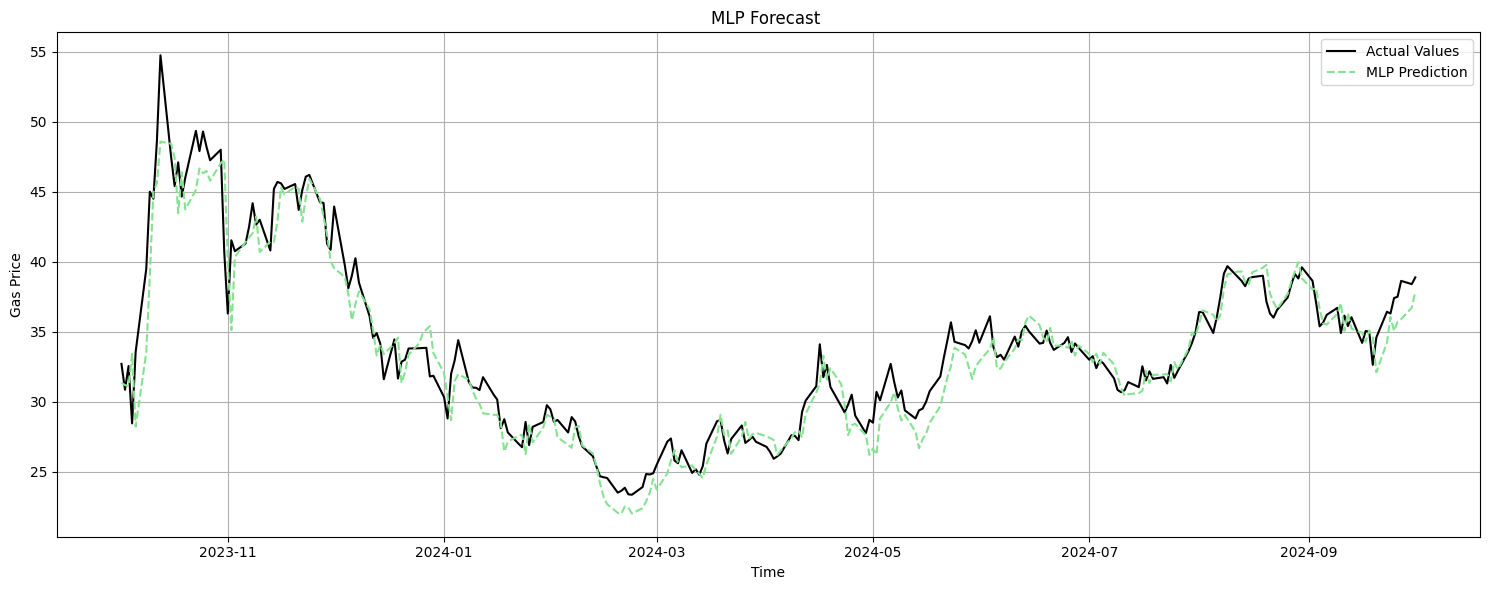

In [2]:
# Zeitreihen-CV definieren
tscv = TimeSeriesSplit(n_splits=4)

# Ausgewählte Features
selected_features = ['S-Gas DA D', 'N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30', 'S-Coal Price (close)_lag1', 'Season_Winter', 'P-GPR_rollmean_30', 'N-Demand LDZ_rollstd_30', 'P-European_News_Index_lag1', 'P-GPR_lag1', 'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3']


X_train_sel = train_df[selected_features]
X_test_sel = test_df[selected_features]

# Parameterraum für GridSearchCV
mlp_param_grid = {
    'solver': ['adam'],
    'activation': ['tanh', 'relu'],
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.01, 0.1, 1.0],
    'batch_size': [32],
    'epsilon': [1e-07]
}

# GridSearchCV
mlp_search = GridSearchCV(
    MLPRegressor(max_iter=3000, random_state=42, early_stopping=False, n_iter_no_change=20),
    mlp_param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

mlp_search.fit(X_train_sel, train_y_df.values.ravel())
best_mlp = mlp_search.best_estimator_

# Vorhersage
y_pred_scaled = best_mlp.predict(X_test_sel)
y_pred_rescaled = y_min_max_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_holdout_rescaled = y_min_max_scaler.inverse_transform(test_y_df.values.reshape(-1, 1)).flatten()

# Metriken
mae = mean_absolute_error(y_holdout_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_holdout_rescaled, y_pred_rescaled))
r2 = r2_score(y_holdout_rescaled, y_pred_rescaled)

print(f"\nBeste Hyperparameter: {mlp_search.best_params_}")
print(f"MAE (rescaled): {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_holdout_rescaled, label='Actual Values', color='black')
plt.plot(test_y_df.index, y_pred_rescaled, label='MLP Prediction', linestyle='--', color='#84E291')
plt.title('MLP Forecast ')
plt.xlabel('Time')
plt.ylabel('Gas Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



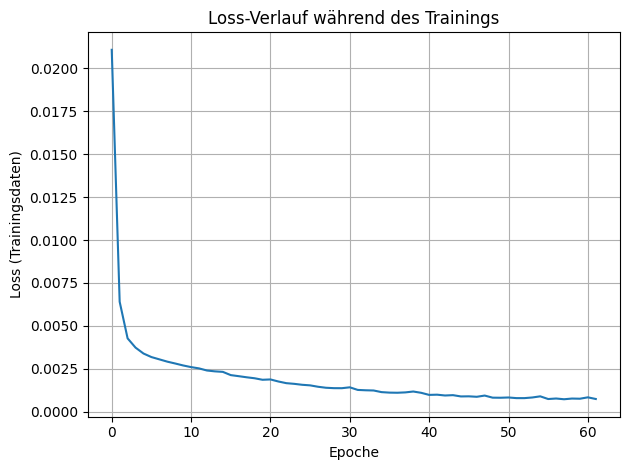

In [15]:


if hasattr(best_mlp, "loss_curve_"):
    plt.plot(best_mlp.loss_curve_)
    plt.title("Loss-Verlauf während des Trainings")
    plt.xlabel("Epoche")
    plt.ylabel("Loss (Trainingsdaten)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("loss_curve_ ist nicht verfügbar.")


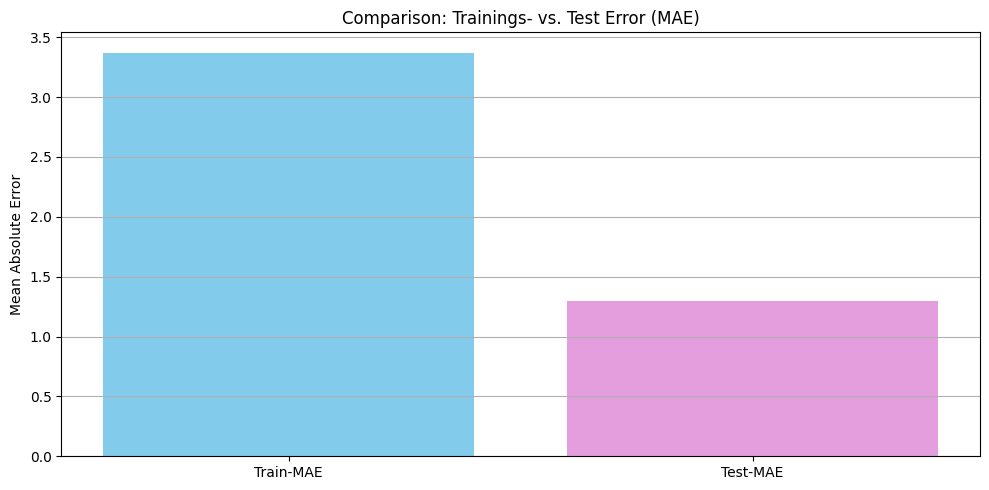

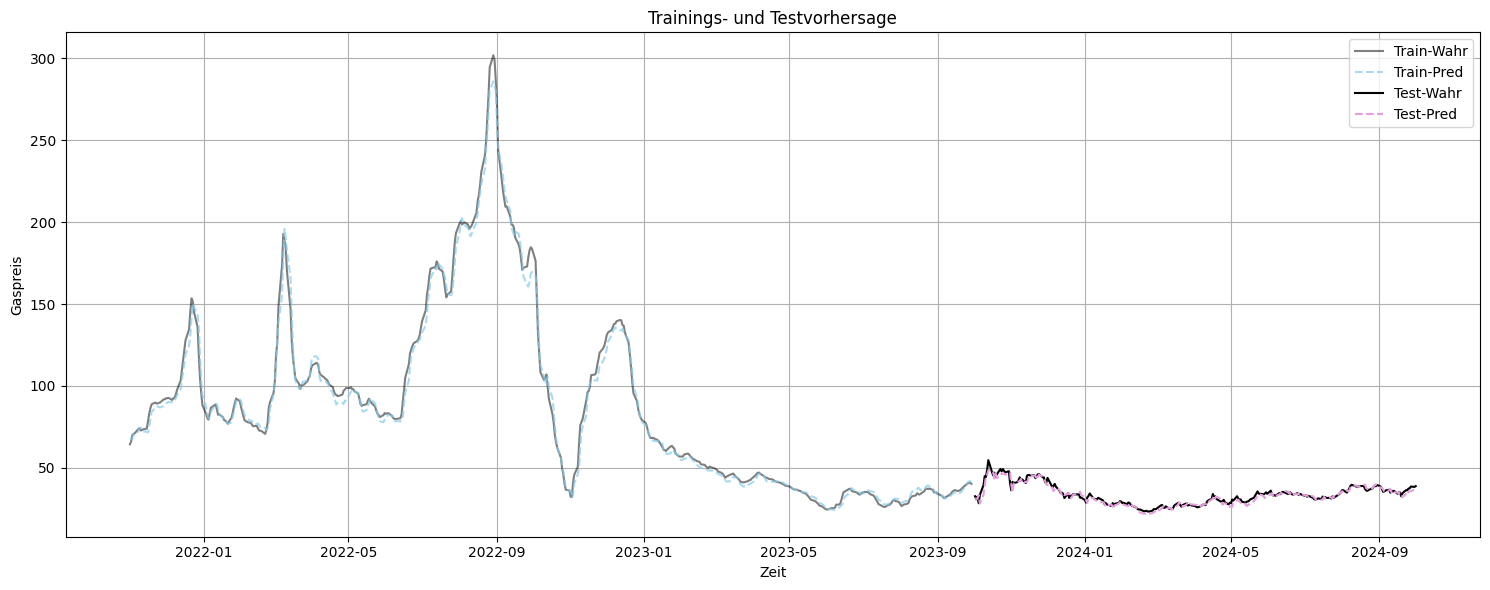

In [6]:
# --- Trainingsfehler berechnen ---
y_train_pred_scaled = best_mlp.predict(X_train_sel)
y_train_pred_rescaled = y_min_max_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_train_rescaled = y_min_max_scaler.inverse_transform(train_y_df.values.reshape(-1, 1)).flatten()

train_mae = mean_absolute_error(y_train_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_holdout_rescaled, y_pred_rescaled)

# --- Fehlerverlauf visualisieren ---
plt.figure(figsize=(10, 5))
plt.bar(['Train-MAE', 'Test-MAE'], [train_mae, test_mae], color=['#83CBEB', '#E59EDD'])
plt.title('Comparison: Trainings- vs. Test Error (MAE)')
plt.ylabel('Mean Absolute Error')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- Optional: Zeitverlauf von Training + Test zeigen ---
plt.figure(figsize=(15, 6))
plt.plot(train_df.index, y_train_rescaled, label='Train-Wahr', color='black', alpha=0.5)
plt.plot(train_df.index, y_train_pred_rescaled, label='Train-Pred', linestyle='--', color='#83CBEB', alpha=0.7)
plt.plot(test_y_df.index, y_holdout_rescaled, label='Test-Wahr', color='black')
plt.plot(test_y_df.index, y_pred_rescaled, label='Test-Pred', linestyle='--', color='#E59EDD')
plt.title('Trainings- und Testvorhersage')
plt.xlabel('Zeit')
plt.ylabel('Gaspreis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
print("Train-Zielwert-Spannweite:", y_train_rescaled.max() - y_train_rescaled.min())
print("Test-Zielwert-Spannweite:", y_holdout_rescaled.max() - y_holdout_rescaled.min())

Train-Zielwert-Spannweite: 277.257
Test-Zielwert-Spannweite: 31.4


In [10]:
model_filename = 'mlp_0306.pkl'

# Speichern des Modells
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"\nBestes Modell wurde unter '{model_filename}' gespeichert.")


Bestes Modell wurde unter 'mlp_0306.pkl' gespeichert.


### without gasprice and GridSearch


MAE (rescaled): 26.2497
RMSE: 30.2323
R²: -23.1006


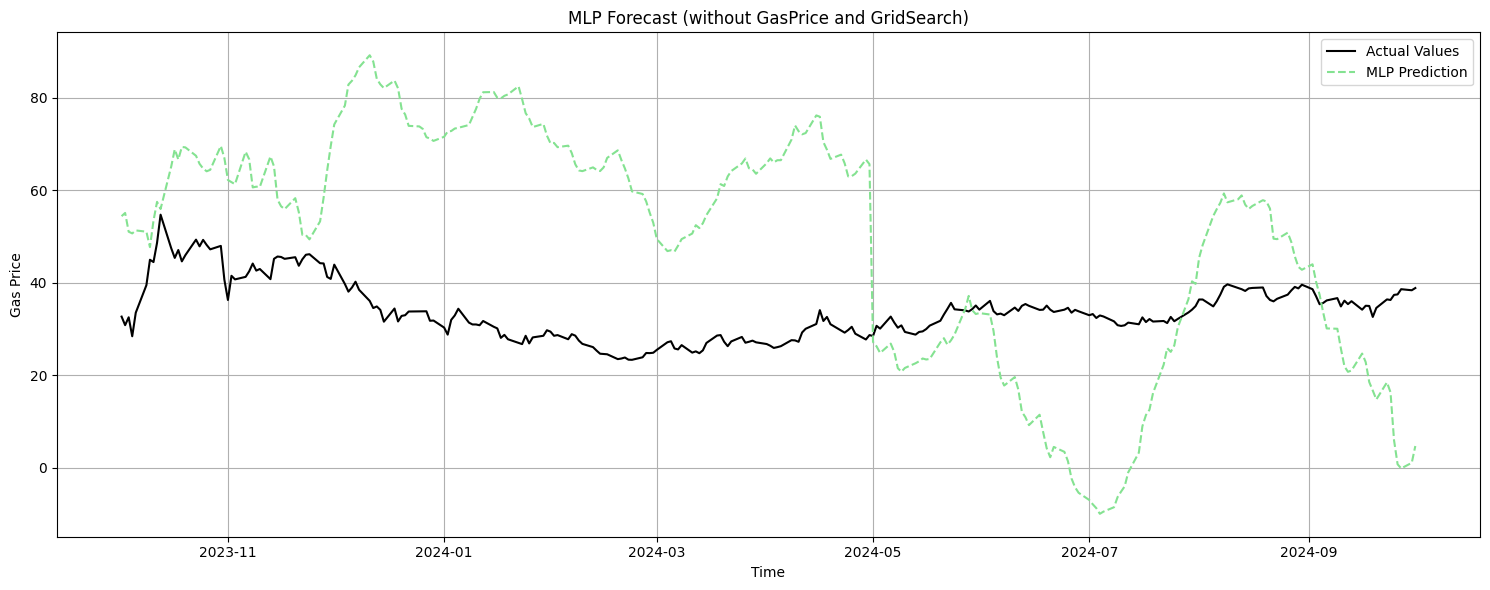

In [13]:
# Zeitreihen-CV definieren
tscv = TimeSeriesSplit(n_splits=4)

# Ausgewählte Features
selected_features = ['N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30', 'S-Coal Price (close)_lag1', 'Season_Winter', 'P-GPR_rollmean_30', 'N-Demand LDZ_rollstd_30', 'P-European_News_Index_lag1', 'P-GPR_lag1', 'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3']

X_train_sel = train_df[selected_features]
X_test_sel = test_df[selected_features]

# Modell mit besten Parametern trainieren
best_mlp_manual = MLPRegressor(
    max_iter=3000,
    random_state=42,
    early_stopping=False,
    n_iter_no_change=20,
    **mlp_search.best_params_
)
best_mlp_manual.fit(X_train_sel, train_y_df.values.ravel())

# Vorhersage
y_pred_scaled = best_mlp_manual.predict(X_test_sel)
y_pred_rescaled = y_min_max_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_holdout_rescaled = y_min_max_scaler.inverse_transform(test_y_df.values.reshape(-1, 1)).flatten()

# Metriken
mae = mean_absolute_error(y_holdout_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_holdout_rescaled, y_pred_rescaled))
r2 = r2_score(y_holdout_rescaled, y_pred_rescaled)

print(f"\nMAE (rescaled): {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_holdout_rescaled, label='Actual Values', color='black')
plt.plot(test_y_df.index, y_pred_rescaled, label='MLP Prediction', linestyle='--', color='#84E291')
plt.title('MLP Forecast (without GasPrice and GridSearch)')
plt.xlabel('Time')
plt.ylabel('Gas Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### untuned

MAE (rescaled): 3.8183
RMSE: 4.8792
R²: 0.3723


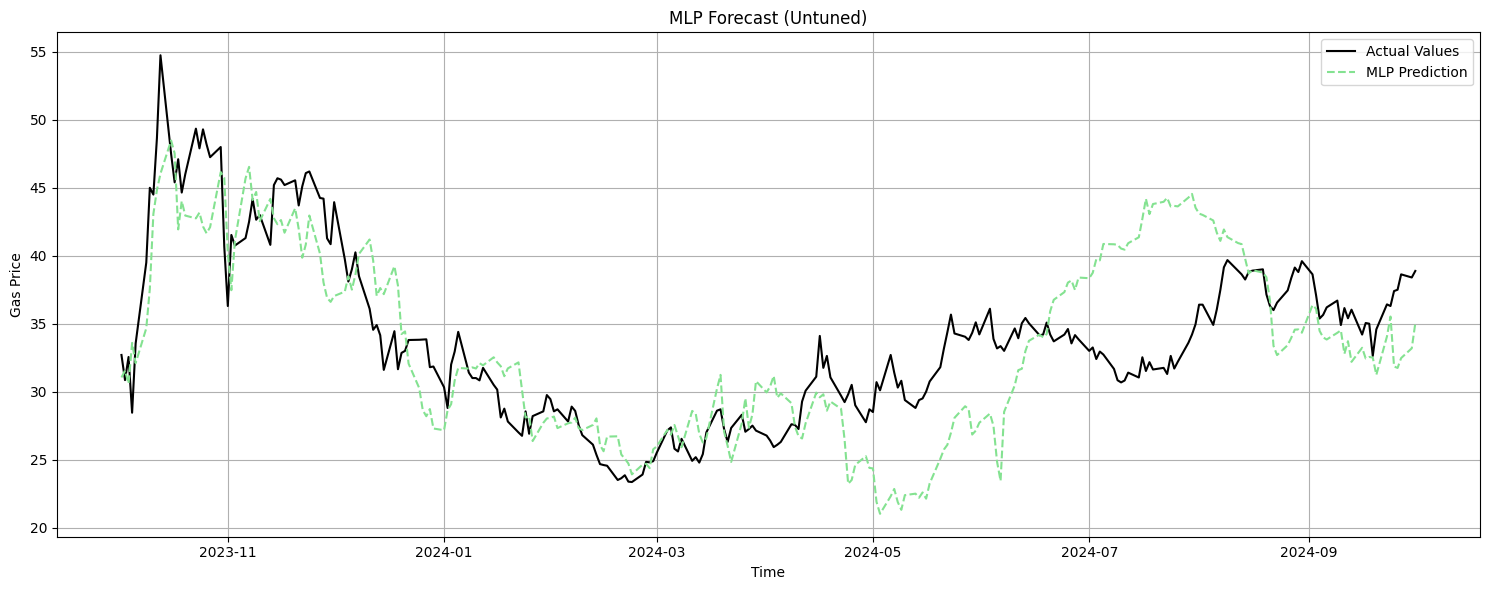

In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Zeitreihen-CV definieren
tscv = TimeSeriesSplit(n_splits=4)

# Features
selected_features = ['S-Gas DA D', 'N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 
                     'P-European_News_Index_rollmean_30', 'S-Coal Price (close)_lag1', 
                     'Season_Winter', 'P-GPR_rollmean_30', 'N-Demand LDZ_rollstd_30', 
                     'P-European_News_Index_lag1', 'P-GPR_lag1', 
                     'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3']

X_train_sel = train_df[selected_features]
X_test_sel = test_df[selected_features]

# Untuned MLP
mlp = MLPRegressor()

# Training
mlp.fit(X_train_sel, train_y_df.values.ravel())

# Vorhersage
y_pred_scaled = mlp.predict(X_test_sel)
y_pred_rescaled = y_min_max_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_holdout_rescaled = y_min_max_scaler.inverse_transform(test_y_df.values.reshape(-1, 1)).flatten()

# Metriken
mae = mean_absolute_error(y_holdout_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_holdout_rescaled, y_pred_rescaled))
r2 = r2_score(y_holdout_rescaled, y_pred_rescaled)

print(f"MAE (rescaled): {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_holdout_rescaled, label='Actual Values', color='black')
plt.plot(test_y_df.index, y_pred_rescaled, label='MLP Prediction', linestyle='--', color='#84E291')
plt.title('MLP Forecast (Untuned)')
plt.xlabel('Time')
plt.ylabel('Gas Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## SHAP


In [7]:
# Shap Values berechnen
import shap
from sklearn.model_selection import train_test_split

X_shap_bg, X_shap_target = train_test_split(X_train_sel, test_size=0.9, random_state=42)
# SHAP-Explainer für MLP
explainer = shap.KernelExplainer(best_mlp.predict, X_shap_bg)

# SHAP-Werte berechnen
shap_values = explainer.shap_values(X_shap_target)



c:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Python 3.12\venvMasterarbeit\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 450/450 [01:23<00:00,  5.37it/s]


SHAP-Waterfall: Sample 0


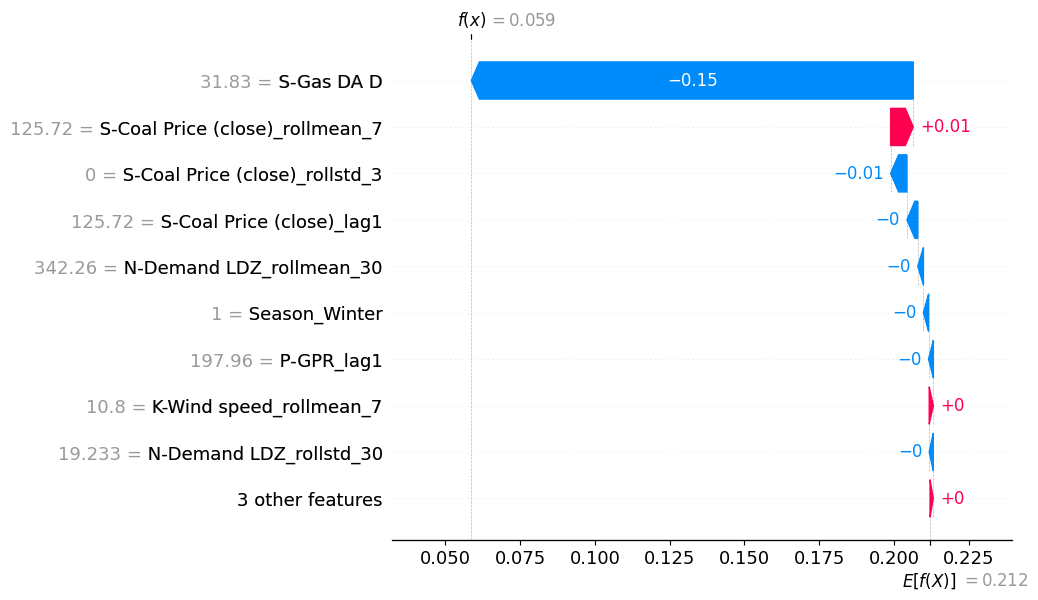

SHAP-Waterfall: Sample 60


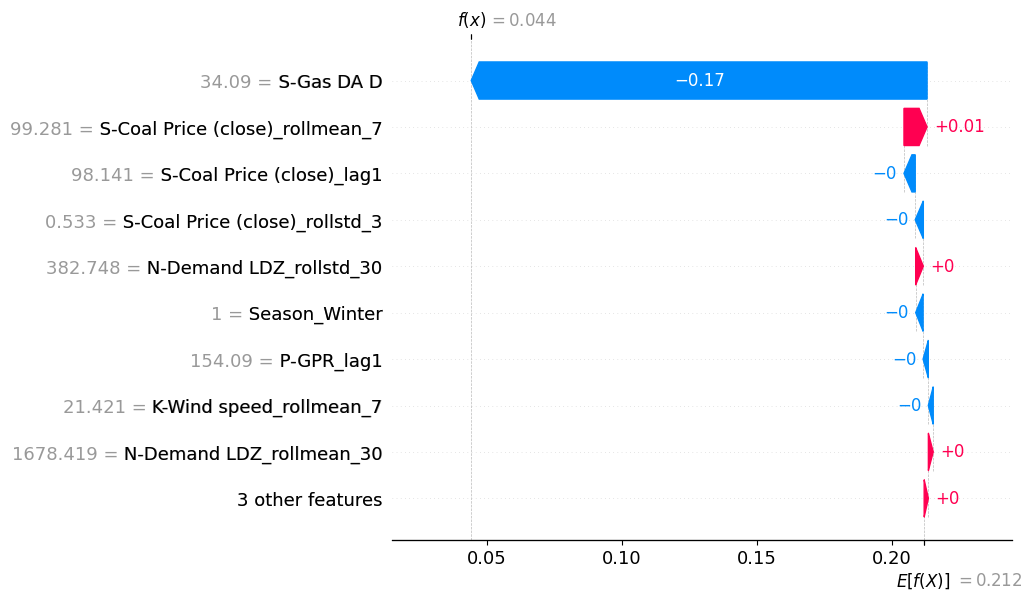

SHAP-Waterfall: Sample 120


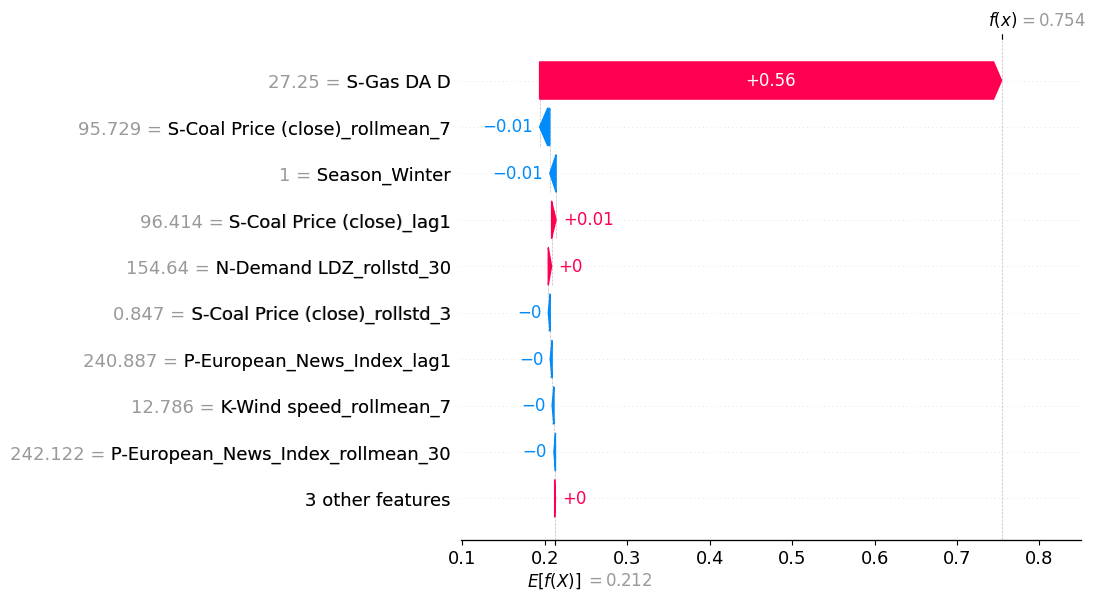

SHAP-Waterfall: Sample 180


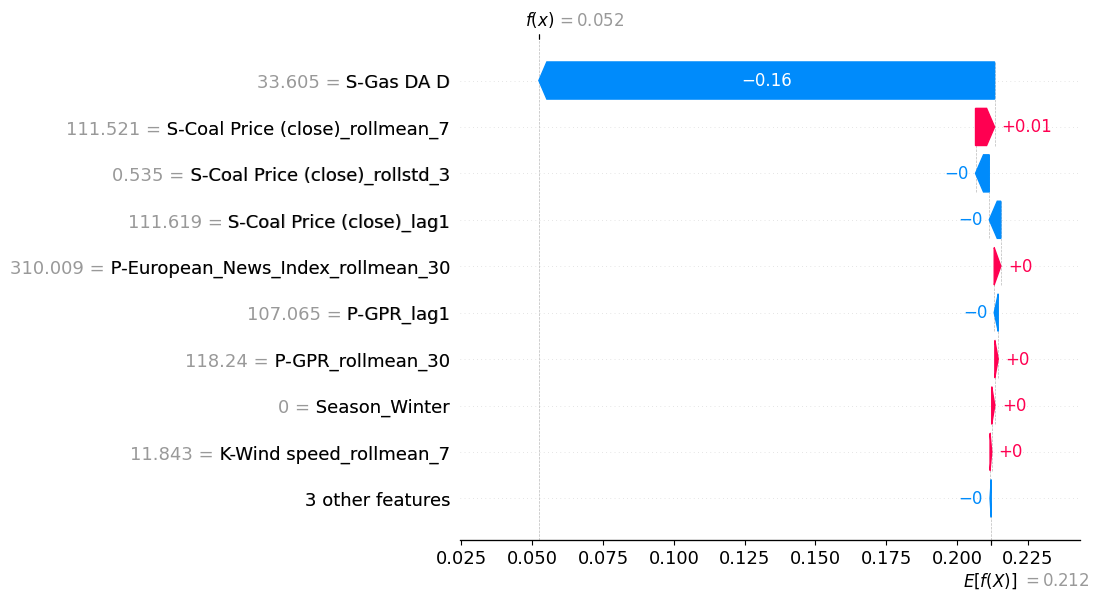

SHAP-Waterfall: Sample 240


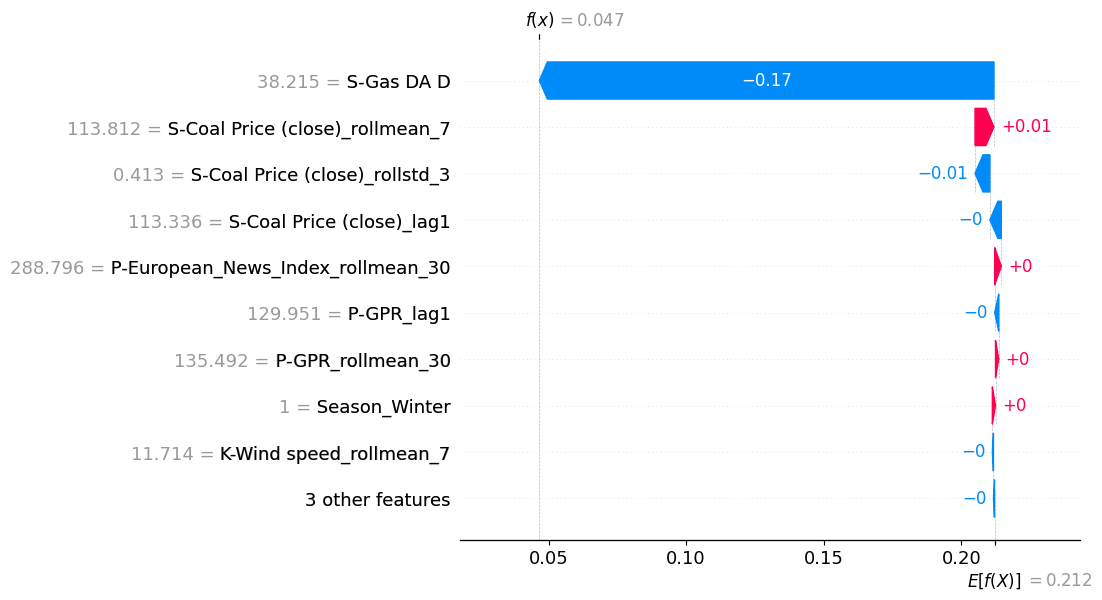

In [17]:

# 1. Pickle-Dateien laden
with open('unscaled_test_final_df.pkl', 'rb') as f:
    unscaled_test_final_df = pickle.load(f)

with open('unscaled_train_final_df.pkl', 'rb') as f:
    unscaled_train_final_df = pickle.load(f)

# 2. Features einschränken
X_test_sel_unscaled = unscaled_test_final_df[selected_features]

# 3. Indizes auswählen (jede 60. Instanz)
indices = list(range(0, len(X_test_sel_unscaled), 60))

# 4. Plots untereinander anzeigen
for i in indices:
    print(f"SHAP-Waterfall: Sample {i}")
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[i],
            base_values=explainer.expected_value,
            data=X_test_sel_unscaled.iloc[i],
            feature_names=X_test_sel_unscaled.columns
        )
    )


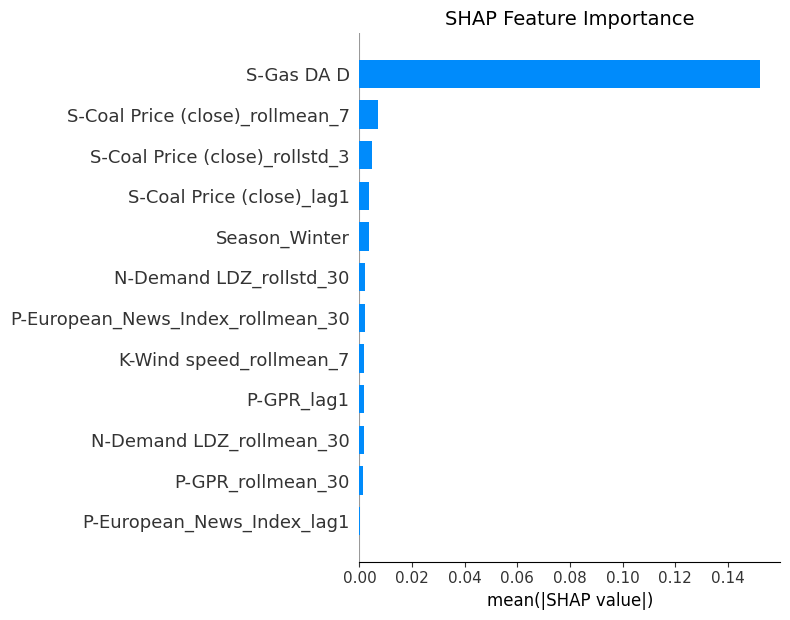

In [19]:
shap.summary_plot(
    shap_values,
    X_shap_target,
    plot_type="bar",
    max_display=20,
    show=False  # wichtig, damit du plt danach anpassen kannst
)
plt.xlabel("mean(|SHAP value|)", fontsize=12)
plt.title("SHAP Feature Importance", fontsize=14)
plt.tight_layout()
plt.show()

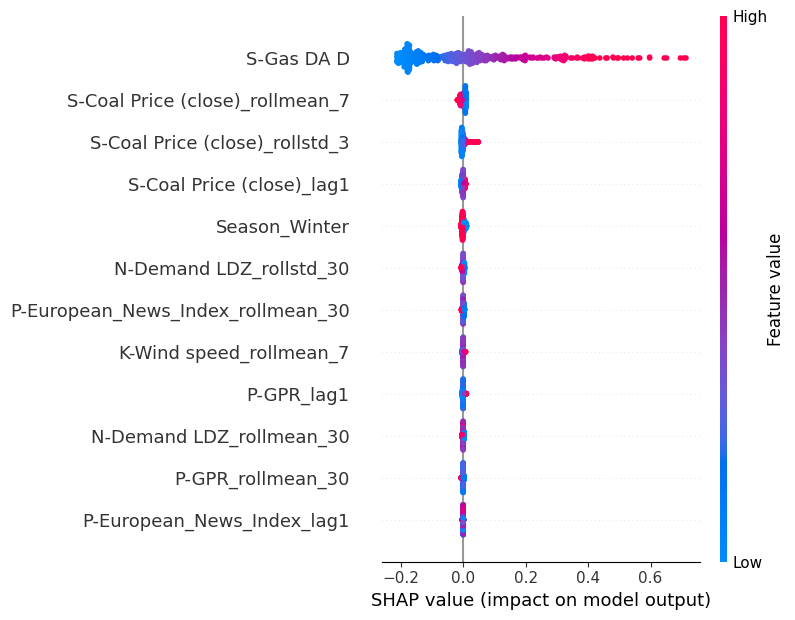

In [20]:

# 2. Summary Plot (Beeswarm)
shap.summary_plot(
    shap_values,
    X_shap_target,
    max_display=20
)


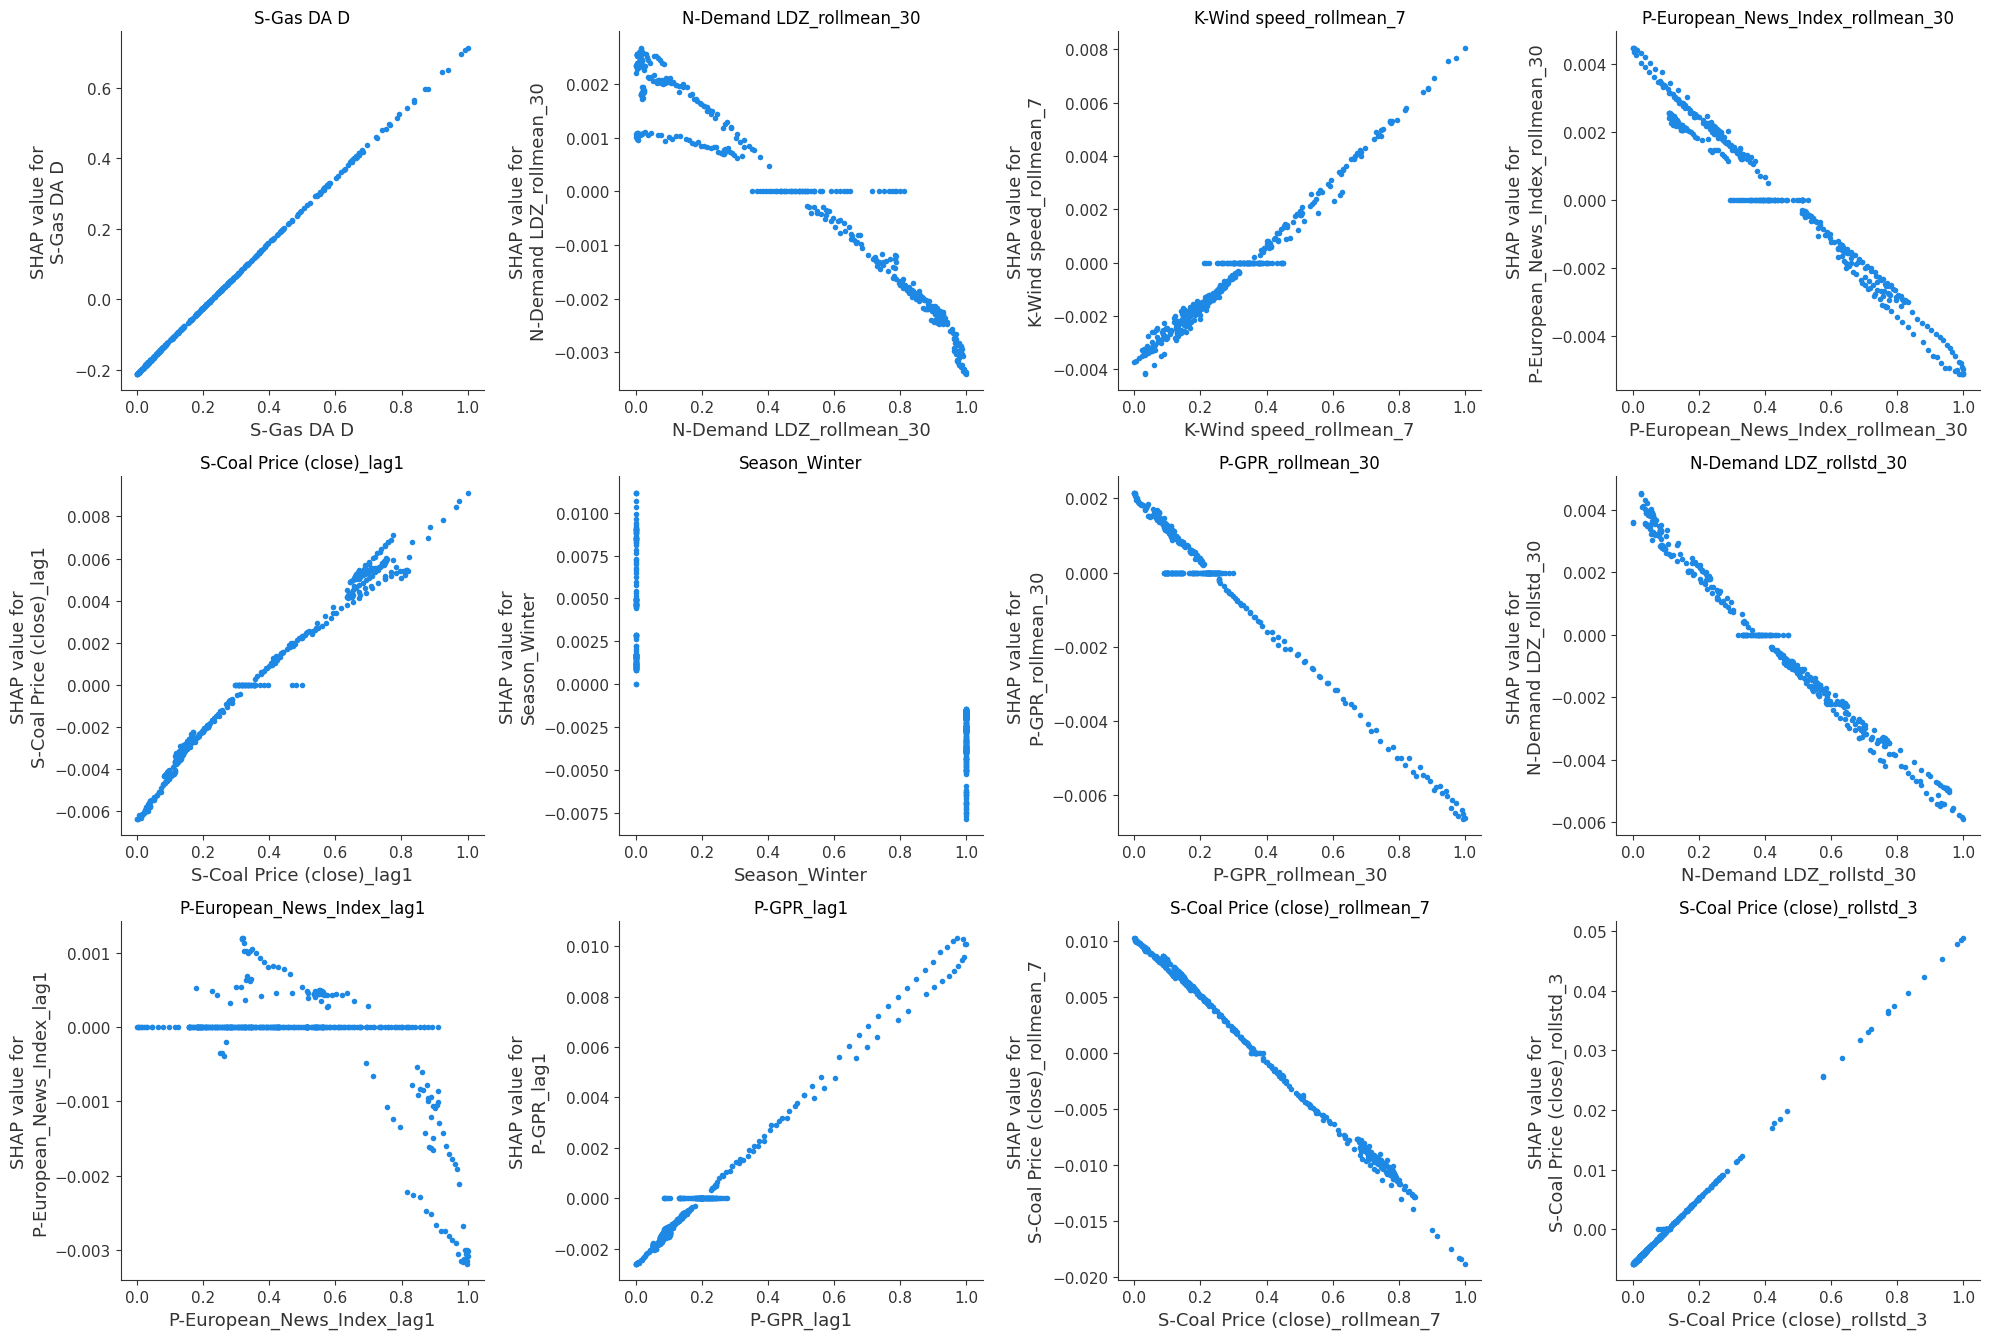

In [21]:
#Dependence Plots für alle Features (ohne Interaktion)
n_feat = len(X_shap_target.columns)

# Grid für alle Dependence-Plots vorbereiten (z. B. 3x3, 4x4 etc.)
n_cols = int(np.ceil(np.sqrt(n_feat)))
n_rows = int(np.ceil(n_feat / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4.5 * n_rows))
axes = axes.flatten()

# Für jedes Feature einen Dependence-Plot zeichnen (ohne Interaktion)
for i, feat in enumerate(X_shap_target.columns):
    shap.dependence_plot(
        feat,
        shap_values,
        X_shap_target,
        interaction_index=None,
        show=False,
        ax=axes[i]
    )
    axes[i].set_title(feat)

# Überzählige Achsen entfernen
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


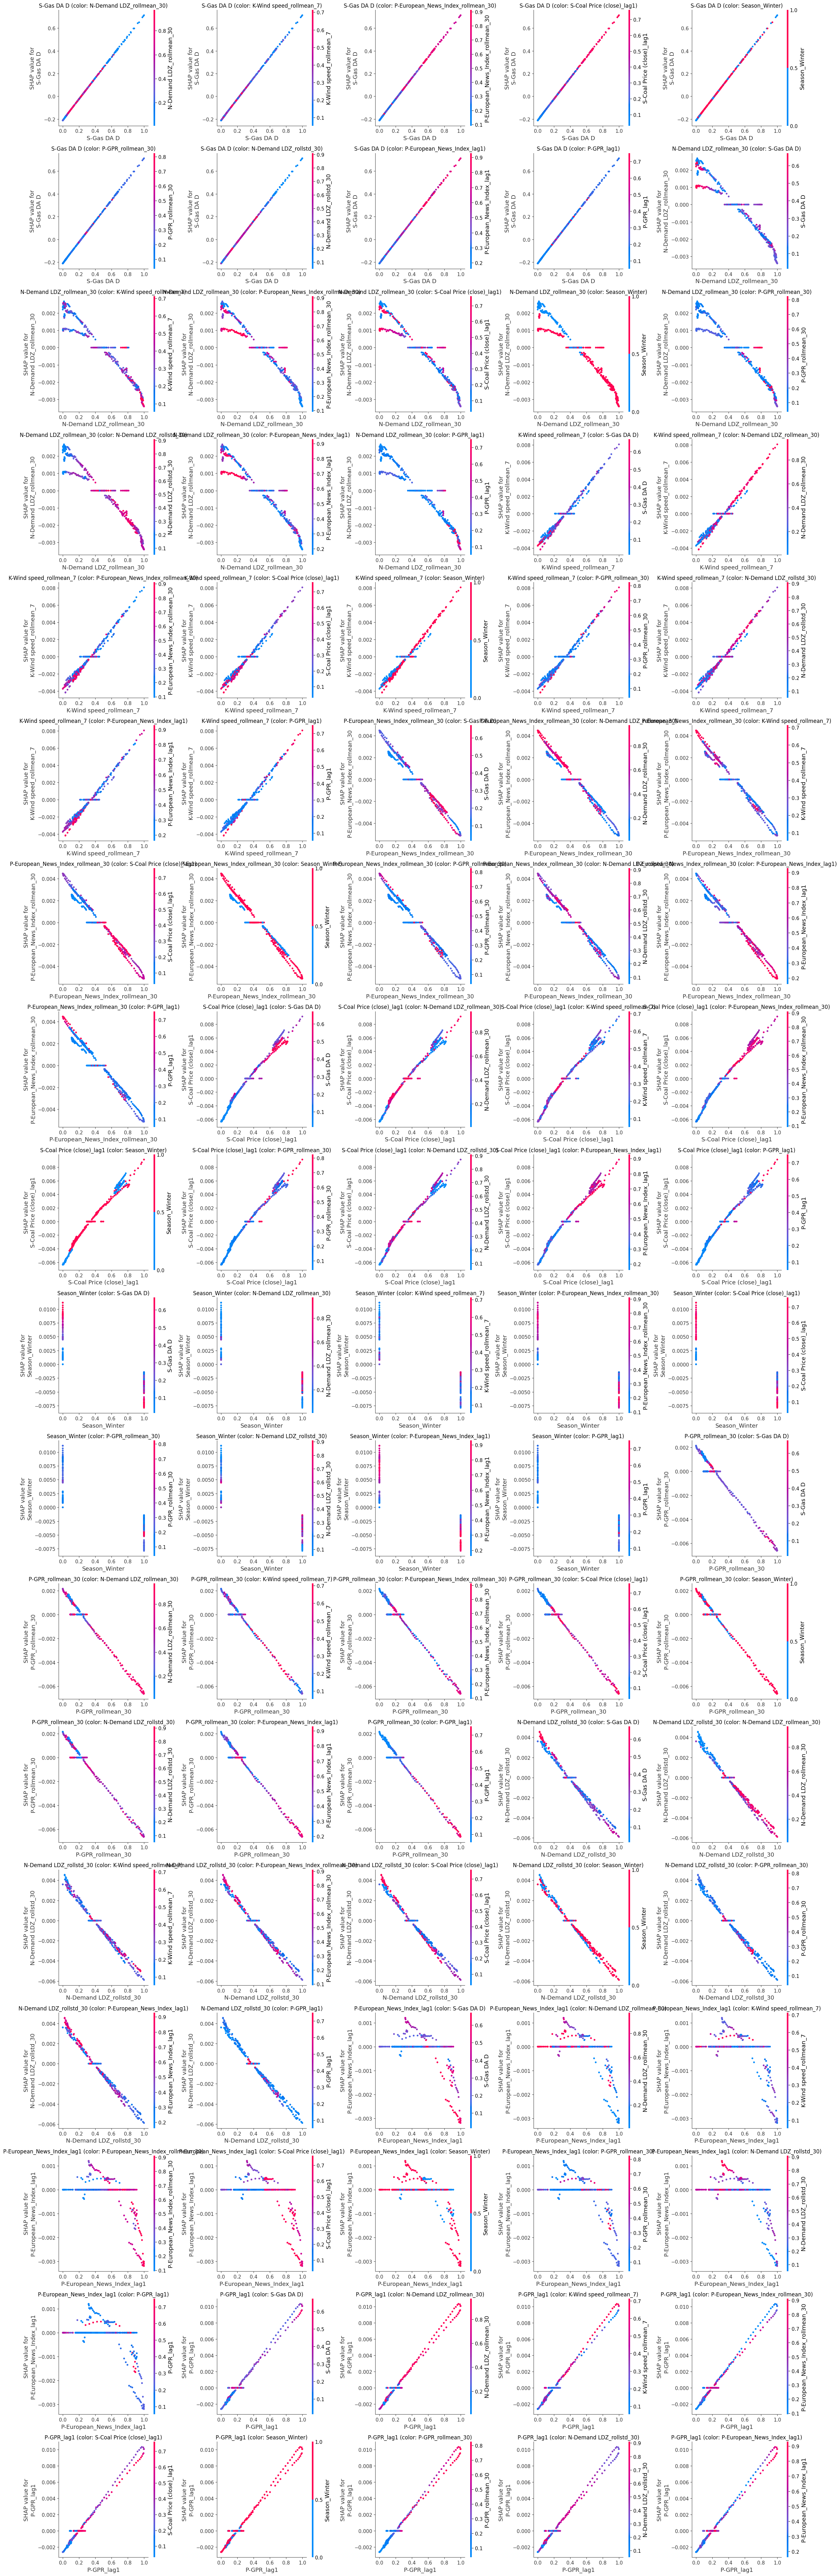

In [22]:


n_feat = 10
cols = X_shap_target.columns[:n_feat]

# Alle gerichteten Kombinationen (i ≠ j)
interactions = [(cols[i], cols[j]) for i in range(n_feat) for j in range(n_feat) if i != j]

n_plots = len(interactions)  # = 90 bei 10 Features
n_cols = 5
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4.5 * n_rows))
axes = axes.flatten()

for idx, (f1, f2) in enumerate(interactions):
    shap.dependence_plot(
        f1,
        shap_values,
        X_shap_target,
        interaction_index=f2,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f"{f1} (color: {f2})")

# Leere Achsen entfernen
for i in range(len(interactions), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


#### Dependence for thesis

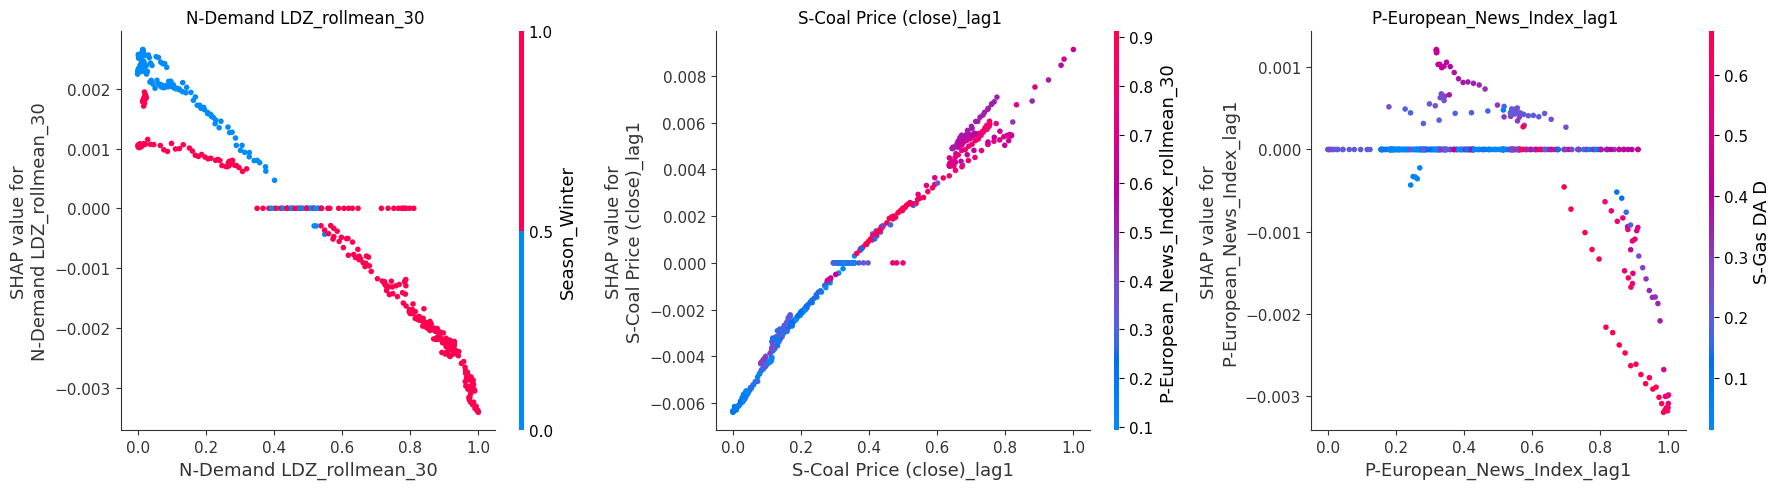

In [9]:


interactions = [
    ("N-Demand LDZ_rollmean_30", "Season_Winter"),
    ("S-Coal Price (close)_lag1", "P-European_News_Index_rollmean_30"),
    ("P-European_News_Index_lag1", "S-Gas DA D")
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (f1, f2) in enumerate(interactions):
    shap.dependence_plot(
        f1,
        shap_values,
        X_shap_target,
        interaction_index=f2,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f"{f1} ")

plt.tight_layout()
plt.show()


### SHAP with test_set in comparison 

In [23]:


# SHAP auf Trainingsdaten
X_shap_bg_train, X_shap_target_train = train_test_split(X_train_sel, test_size=0.9, random_state=42)
explainer_train = shap.KernelExplainer(best_mlp.predict, X_shap_bg_train)
shap_values_train = explainer_train.shap_values(X_shap_target_train)

# SHAP auf Testdaten
X_shap_bg_test, X_shap_target_test = train_test_split(X_test_sel, test_size=0.9, random_state=42)
explainer_test = shap.KernelExplainer(best_mlp.predict, X_shap_bg_test)
shap_values_test = explainer_test.shap_values(X_shap_target_test)



  0%|          | 0/450 [00:00<?, ?it/s]

100%|██████████| 236/236 [00:27<00:00,  8.56it/s]


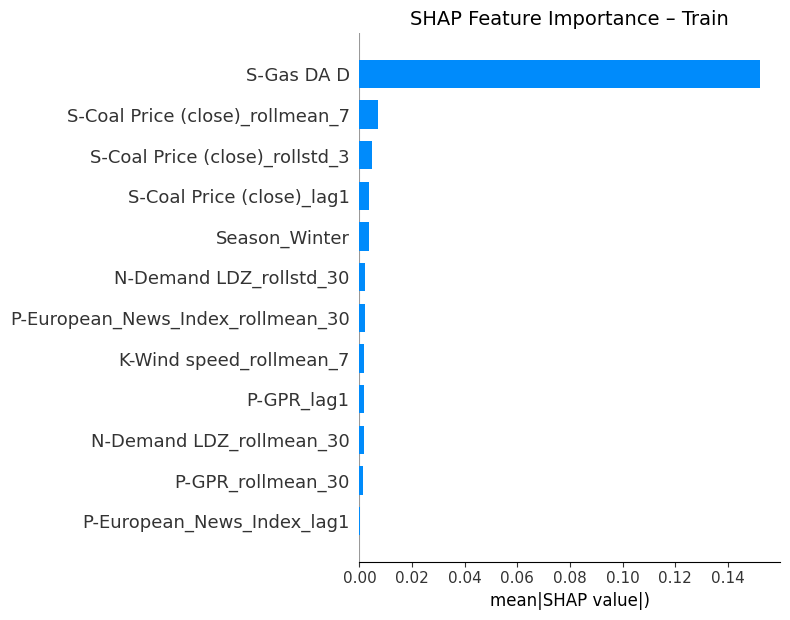

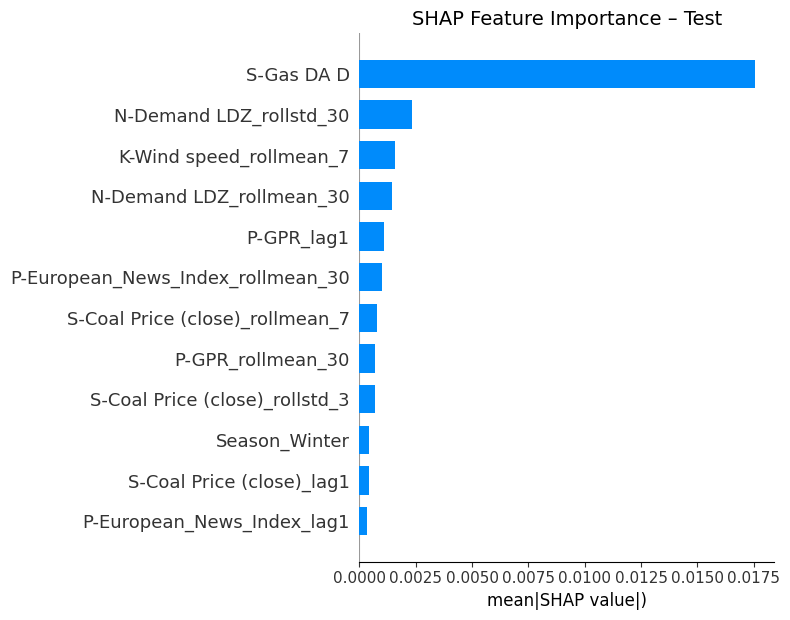

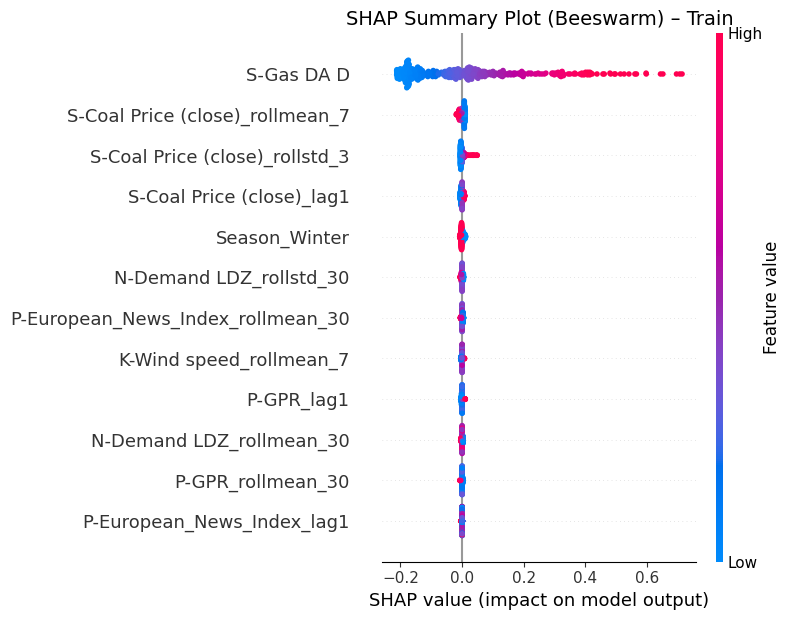

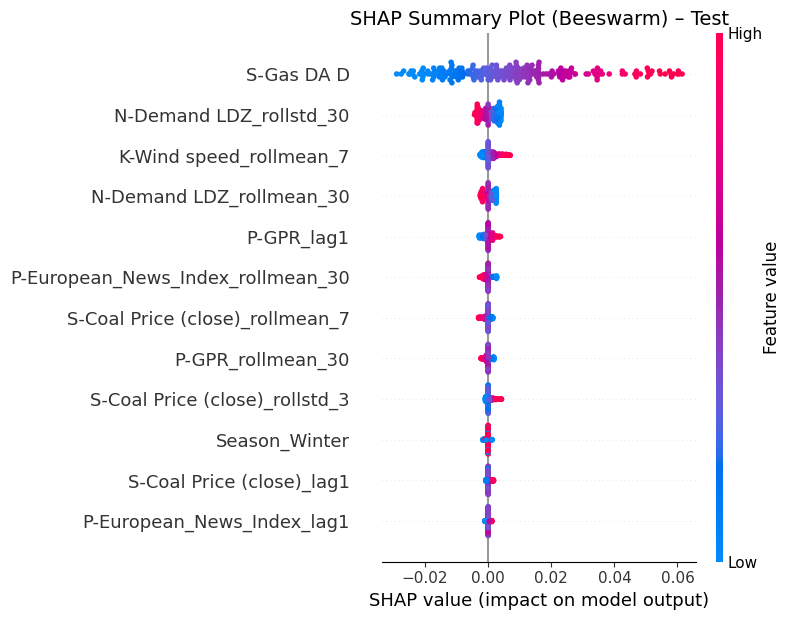

In [25]:

# SHAP Barplot – Train
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values_train, X_shap_target_train, plot_type="bar", show=False)
plt.xlabel("mean|SHAP value|)", fontsize=12)
plt.gca().set_title("SHAP Feature Importance – Train", fontsize=14)
plt.tight_layout()
plt.show()

# SHAP Barplot – Test
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values_test, X_shap_target_test, plot_type="bar", show=False)
plt.xlabel("mean|SHAP value|)", fontsize=12)
plt.gca().set_title("SHAP Feature Importance – Test", fontsize=14)
plt.tight_layout()
plt.show()

# SHAP Beeswarm – Train
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values_train, X_shap_target_train, plot_type="dot", show=False)
plt.gca().set_title("SHAP Summary Plot (Beeswarm) – Train", fontsize=14)
plt.tight_layout()
plt.show()

# SHAP Beeswarm – Test
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values_test, X_shap_target_test, plot_type="dot", show=False)
plt.gca().set_title("SHAP Summary Plot (Beeswarm) – Test", fontsize=14)
plt.tight_layout()
plt.show()
